In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, for csv,text etc files....


import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
#nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize


In [2]:
spam_folder =r'F:\python_spam\flask_app\dataset\spam'
ham_folder =r'F:\python_spam\flask_app\dataset\ham'

ham_filenames = [name for name in sorted(os.listdir(ham_folder)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(spam_folder)) if len(name) > 20]


In [3]:
print('Number of non-spam samples:', len(ham_filenames))
print('Number of spam samples:', len(spam_filenames))
print('Ratio of non-spam to spam samples:', len(ham_filenames)/len(spam_filenames))

Number of non-spam samples: 3672
Number of spam samples: 1500
Ratio of non-spam to spam samples: 2.448


In [4]:
import email
import email.policy

def load_email(is_spam, filename):
    directory = spam_folder if is_spam else ham_folder
    
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [5]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

ham_structure = structures_counter(ham_emails)
spam_structure = structures_counter(spam_emails)


In [6]:
def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"

In [7]:
def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)
        
print(email_to_plain(ham_emails[42]))
print(email_to_plain(spam_emails[45]))


i will be out of the office beginning thursday , 12 / 24 , returning on tuesday ,
1 / 4 . in my absence , i have asked steve venturatos to be the point person for
texas operations .
i realize that many of you will be working over the new year ' s week - end to
ensure a smooth transaction into the new year . in advance , i truly
appreciate all of the efforts . additionally , i would like to be kept
informed on any critical issues , mainly so that i have no surprises when i
return . therefore , i have provided numbers below where i can be reached . i
will leave it to your discretion as to whether you call me or leave me a
voice mail in the office . as you all know , i would rather be informed than
surprised !
pager 877 - 497 - 3757
cellular 713 - 417 - 2995
home 970 - 920 - 2293 &
970 - 920 - 2294
thanks to each of you for your dedication . i hope each of you have a
wonderful and safe holiday !
= ? iso - 8859 - 7 ? q ? nup ? =
a premium source for vgr , vlm , xnx ! get popular yet hard t

In [8]:
# structure all emails into plain text
ham_emails_plain = [email_to_plain(email) for email in ham_emails if len(ham_emails) > 100]
spam_emails_plain = [email_to_plain(email) for email in spam_emails if len(spam_emails) > 100]

#ham_structure = structures_counter(ham_emails_plain)
#ham_structure.most_common()

In [9]:
# some data conversion to get it into pandas
ham_dic = {}
spam_dic = {}
ham_dic['text'] = ham_emails_plain
spam_dic['text'] = spam_emails_plain

ham_df = pd.DataFrame(ham_dic, columns = ['text', 'category'])
spam_df = pd.DataFrame(spam_dic, columns = ['text', 'category'])
print(ham_df.head())
print(spam_df.head())


                                                text category
0                                                         NaN
1  gary , production from the high island larger ...      NaN
2             - calpine daily gas nomination 1 . doc      NaN
3  fyi - see note below - already done .\nstella\...      NaN
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      NaN
                                                text category
0  introducing\ndoctor - formulated\nhgh\nhuman g...      NaN
1  low cost prescription medications\nsoma , ultr...      NaN
2  people nowthe weather or climate in any partic...      NaN
3  dear partner ,\nwe are a team of government of...      NaN
4  stock\nprofile\nabout\ncompany\ninvestment\nhi...      NaN


In [10]:
# setting labels
ham_df['category'] = 0
spam_df['category'] = 1

frames = [ham_df, spam_df]

# dataframe of messages with proper labels for spam and non-spam
messages = pd.concat(frames).reset_index(drop=True)
messages

,text,category
0,,0
1,"gary , production from the high island larger ...",0
2,- calpine daily gas nomination 1 . doc,0
3,fyi - see note below - already done .\nstella\...,0
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,0
...,...,...
5167,"divide cover most gave . trip , until energy ,...",1
5168,{ bodyhtml },1
5169,"61 bb\nhey derm\nbbbbb\ncheck out paris , and ...",1
5170,global marketing specialties po box 300 east a...,1


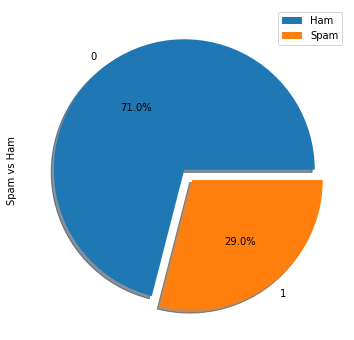

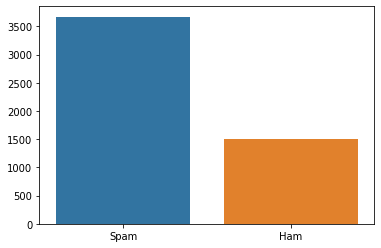

In [11]:
# Dropping rows with NA values
messages.dropna(inplace=True)

messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()
sns.barplot(x=['Spam','Ham'],y=[messages["category"].value_counts()[0],messages["category"].value_counts()[1]])

plt.show()

In [12]:
import nltk
#nltk.download('stopwords')
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
#import nltk
#nltk.download('punkt')
from nltk import word_tokenize

In [14]:

spam_messages = messages[messages["category"] == 1]["text"]
ham_messages = messages[messages["category"] == 0]["text"]
spam_words = []
ham_words = []

In [15]:
 
def extractSpamWords(spamMessages):
    global spam_words, spam_exception_count
    spam_exception_count = 0
    try:
        word_tokenized = word_tokenize(spamMessages)
        words = [word.lower() for word in word_tokenized if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
        spam_words = spam_words + words
    except:
        spam_exception_count += 1
        
def extractHamWords(hamMessages):
    global ham_words, ham_exception_count
    ham_exception_count = 0
    try:
        word_tokenized = word_tokenize(hamMessages)
        words = [word.lower() for word in  word_tokenized if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
        ham_words = ham_words + words
    except:
        ham_exception_count += 1
        
    
# Checking tokenization errors. At some point I had to troubleshoot the code
spam_messages.apply(extractSpamWords)
print('spam exception count: ', spam_exception_count)
ham_messages.apply(extractHamWords)
print('ham exception count: ', ham_exception_count)


spam exception count:  0
ham exception count:  0


In [16]:
# %pip install wordcloud
from wordcloud import WordCloud

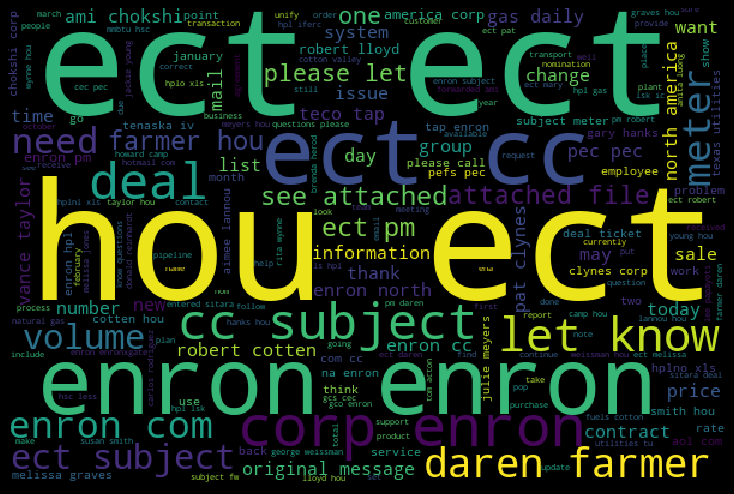

In [17]:
from wordcloud import WordCloud
ham_wordcloud=WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

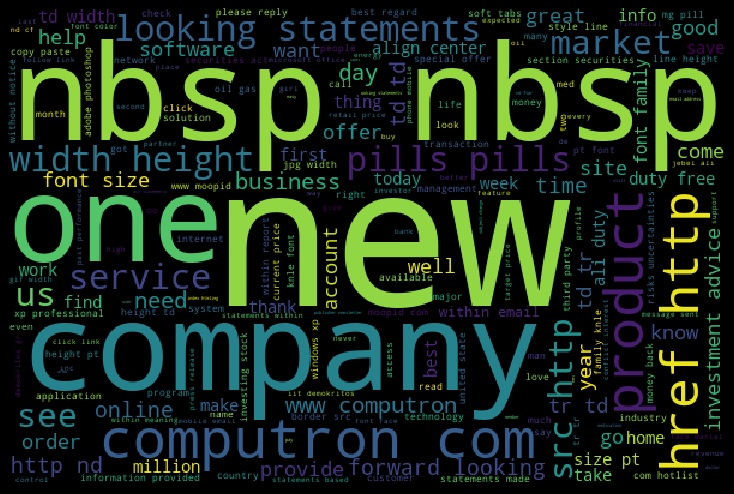

In [18]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
sp_df=pd.Series(spam_words).value_counts().head(n = 10)
print(sp_df)
ham_words = np.array(ham_words)
print("\nTop 10 Ham words are :\n")
ha_df=pd.Series(ham_words).value_counts().head(n = 10)
print(ha_df)


Top 10 Spam words are :

com            991
http           983
company        726
e              613
www            587
information    513
font           511
td             504
statements     476
please         475
dtype: int64

Top 10 Ham words are :

ect        13893
hou         7281
enron       6279
subject     2728
please      2697
com         2693
deal        2655
gas         2629
cc          2357
pm          2325
dtype: int64


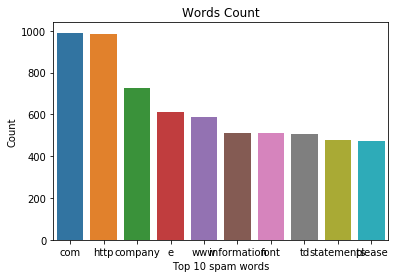

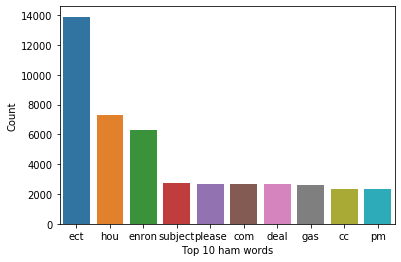

In [20]:
sns.barplot(x=sp_df.index,y=sp_df.values)
plt.xlabel('Top 10 spam words')
plt.ylabel("Count")
plt.title("Words Count")
plt.show()
sns.barplot(x=ha_df.index,y=ha_df.values)
plt.xlabel('Top 10 ham words')
plt.ylabel("Count")
plt.show()

In [21]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count     5172.000000
mean       986.755607
std       1502.989698
min          0.000000
25%        200.000000
50%        486.000000
75%       1171.000000
max      31817.000000
Name: messageLength, dtype: float64

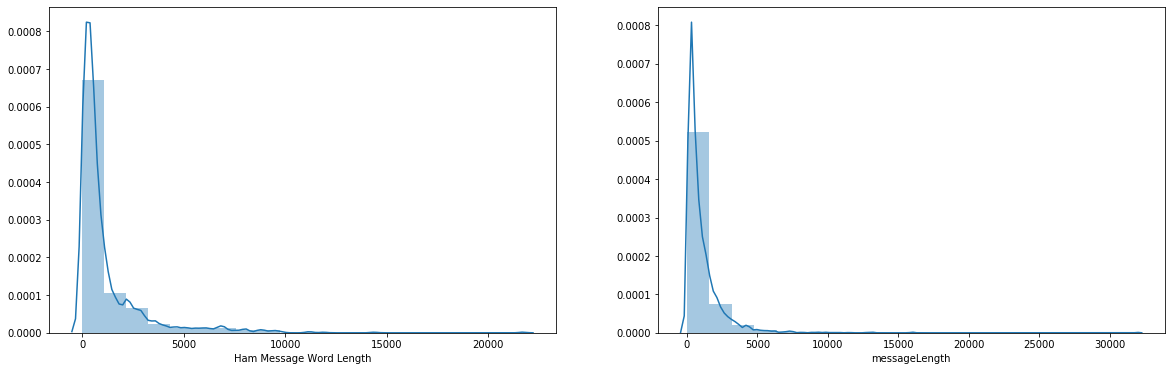

In [22]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == 1]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == 0]["messageLength"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

In [23]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    try:
        message = message.translate(str.maketrans('', '', string.punctuation))
        words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
        return " ".join(words)
    except:
        print(message)
        
    
messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)    


,text,category,messageLength
0,,0,0
1,gari product high island larger block 1 2 comm...,0,4282
2,calpin daili gas nomin 1 doc,0,38
3,fyi see note alreadi done stella forward stell...,0,1171
4,fyi forward lauri allen hou ect 12 14 99 12 17...,0,1124
5,jacki sinc inlet 3 river plant shut 10 19 99 l...,0,534
6,georg need follow done jan 13 zero 012 27049 0...,0,411
7,fyi forward gari l payn hou ect 12 14 99 02 35...,0,1375
8,two field gas difficulti unifi system 1 cage r...,0,1616
9,thank much memo would like reiter support two ...,0,3039


In [24]:
##avergaelegth of mails
avg_ham=messages[messages['category']==0]
print('ham length->>',np.mean(avg_ham['messageLength']),"max ->>",np.max(avg_ham['messageLength']),"Min ->>",np.min(avg_ham['messageLength']))
avg_spam=messages[messages['category']==1]
print('spam length->>',np.mean(avg_spam['messageLength']),"max ->>",np.max(avg_spam['messageLength']),"Min ->>",np.min(avg_spam['messageLength']))


ham length->> 918.5152505446623 max ->> 31817 Min ->> 0
spam length->> 1153.808 max ->> 21705 Min ->> 0


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["text"])
print(features.shape)

(5172, 41860)


In [30]:
from sklearn.model_selection import train_test_split
print(features.shape)
print(messages["category"].shape)
X_train, X_test, y_train, y_test = train_test_split(features, messages["category"], stratify = messages["category"], test_size = 0.2)

(5172, 41860)
(5172,)


In [26]:
from sklearn.metrics import classification_report

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [28]:
KNN=KNeighborsClassifier()
DTC=DecisionTreeClassifier()
RFC=RandomForestClassifier()
MNB=MultinomialNB()
LOG=LogisticRegression()
SGD=SGDClassifier(max_iter = 100)
SVC=SVC(kernel = 'linear')

In [36]:
KNN.fit(X_train, y_train)
y_pred_KNN=KNN.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * KNN.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * KNN.score(X_test,y_test)))
print(classification_report(y_test, y_pred_KNN))
confusion_matrix(y_test, y_pred_KNN)


Training accuracy: 65.58%
Testing accuracy: 58.55%
              precision    recall  f1-score   support

           0       0.99      0.42      0.59       735
           1       0.41      0.99      0.58       300

    accuracy                           0.59      1035
   macro avg       0.70      0.71      0.59      1035
weighted avg       0.82      0.59      0.59      1035



array([[308, 427],
       [  2, 298]], dtype=int64)

In [39]:
DTC.fit(X_train, y_train)
y_pred_DTC=DTC.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * DTC.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * DTC.score(X_test,y_test)))
print(classification_report(y_test, y_pred_DTC))
confusion_matrix(y_test, y_pred_DTC)


Training accuracy: 99.76%
Testing accuracy: 94.88%
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       735
           1       0.92      0.91      0.91       300

    accuracy                           0.95      1035
   macro avg       0.94      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



array([[710,  25],
       [ 28, 272]], dtype=int64)

In [40]:
RFC.fit(X_train, y_train)
y_pred_RFC=RFC.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * RFC.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * RFC.score(X_test,y_test)))
print(classification_report(y_test, y_pred_RFC))
confusion_matrix(y_test, y_pred_RFC)

Training accuracy: 99.76%
Testing accuracy: 97.39%
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       735
           1       0.94      0.97      0.96       300

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



array([[718,  17],
       [ 10, 290]], dtype=int64)

In [41]:
MNB.fit(X_train, y_train)
y_pred_MNB=MNB.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * MNB.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * MNB.score(X_test,y_test)))
print(classification_report(y_test, y_pred_MNB))
confusion_matrix(y_test, y_pred_MNB)

Training accuracy: 93.98%
Testing accuracy: 89.66%
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       735
           1       0.99      0.65      0.78       300

    accuracy                           0.90      1035
   macro avg       0.93      0.82      0.86      1035
weighted avg       0.91      0.90      0.89      1035



array([[734,   1],
       [106, 194]], dtype=int64)

In [42]:
LOG.fit(X_train, y_train)
y_pred_LOG=LOG.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * LOG.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * LOG.score(X_test,y_test)))
print(classification_report(y_test, y_pred_LOG))
confusion_matrix(y_test, y_pred_LOG)

Training accuracy: 99.25%
Testing accuracy: 98.16%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.95      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



array([[721,  14],
       [  5, 295]], dtype=int64)

In [43]:
SGD.fit(X_train, y_train)
y_pred_SGD=SGD.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * SGD.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * SGD.score(X_test,y_test)))
print(classification_report(y_test, y_pred_SGD))
confusion_matrix(y_test, y_pred_SGD)

Training accuracy: 99.73%
Testing accuracy: 97.68%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       735
           1       0.94      0.98      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035



array([[716,  19],
       [  5, 295]], dtype=int64)

In [44]:
SVC.fit(X_train, y_train)
y_pred_SVC=SVC.predict(X_test)
print("Training accuracy: {:.2f}%".format(100 * SVC.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * SVC.score(X_test,y_test)))
print(classification_report(y_test, y_pred_SVC))
confusion_matrix(y_test, y_pred_SVC)

Training accuracy: 99.64%
Testing accuracy: 98.07%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       735
           1       0.95      0.99      0.97       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



array([[718,  17],
       [  3, 297]], dtype=int64)

In [47]:
pickle.dump(KNN,open('KNN.pkl', 'wb'))
pickle.dump(DTC,open('DTC.pkl', 'wb'))
pickle.dump(RFC,open('RFC.pkl', 'wb'))
pickle.dump(MNB,open('MNB.pkl', 'wb'))
pickle.dump(LOG,open('LOG.pkl', 'wb'))
pickle.dump(SGD,open('SGD.pkl', 'wb'))
pickle.dump(SVC,open('SVC.pkl', 'wb'))
pickle.dump(vec,open('vec.pkl', 'wb'))